# XGBoost to predict the predicted mRS shift

(based on notebook 051)

### Using 7 features (as informed by the feature selection), using the multiclass classification model (as trained in notebook 040) to give the probability (likelihood) that each patient is in each discharge disability class (mRS 0, 1, 2, 3, 4, 5 or 6)

Using just the first kfold for validation (seen in notebooks 011 and 041 that the performance and patterns are consistent across the data divisions).

Examine the patterns that the model identifies in terms of feature importance and SHAP.

### Plain English summary

Let's look at the patterns detected by a model trained on the 7 features as infomred by feature selection, using the first k-fold split.

7 features:
1. prior_disability
1. stroke_severity
1. stroke_team
1. age
1. onset_to_thrombolysis_time
1. any_afib_diagnosis
1. precise_onset_known

### Model and data
Model: XGBoost regressor.\
Patient population: Those get IVT in the dataset\
Feature data: 7 selected features\
Target feature: Predicted mRS shift in discharge disability due to treatment (feature calculated using only those patients that got thrombolysis in the dataset, and seeing their outcome given no treatment)\
Data: The first kfold\

### Aims
What are the patterns that the model detects?

### Observations
Feature importance (as calcualted by XGBoost) is only returned for the model (as a whole) and not per output category.

#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

## Import libraries

In [32]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

import time

Report the time duration to run notebook

In [33]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [34]:
k = 0

Define feature names to be used by the model (will add the one hot encoded feature names after read in the dataset)

In [35]:
target_feature = 'predicted_mrs_shift_due_to_thrombolysis'

selected_features = ["prior_disability", "stroke_severity", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [36]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold'
    notebook: str = '221_'

paths = Paths()

Create output folders if needed

In [37]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

First kfold split, created in notebook 220 - has one hot stroke teams and the calculated target value ()

In [38]:
filename = os.path.join(paths.data_read_path, 
                        ('220_train_' + str(k) + '_mrs_shift.csv'))
train = pd.read_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        ('220_test_' + str(k) + '_mrs_shift.csv'))
test = pd.read_csv(filename)

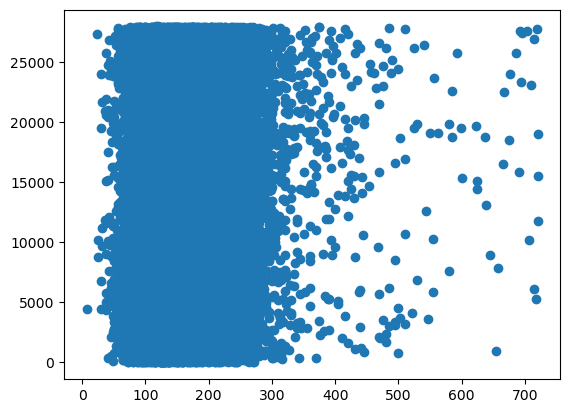

In [39]:
plt.scatter(train["onset_to_thrombolysis_time"],np.arange(train.shape[0]))

Extract the one hot encoded stroke team feature names

In [40]:
ohe_stroke_team_features = [col for col in train.columns if col.startswith('team_')]

And add these to the list of selected features

In [41]:
input_features = selected_features + ohe_stroke_team_features 
n_features = len(input_features)
selected_features = input_features + [target_feature]


In [42]:
train = train[selected_features]
test = test[selected_features]

Create series containing the attended stroke_team for the train and test sets (as the dataset read in contains the one hot encoded version)

In [43]:
def return_attended_stroke_team(data):
    ohe_stroke_team_features = [col for col in data.columns if col.startswith('team')]
    stroke_team = ohe_stroke_team_features * data[ohe_stroke_team_features]
    stroke_team = (data[ohe_stroke_team_features].columns * data[ohe_stroke_team_features]).sum(axis=1)
    stroke_team = [v.replace('team_','') for v in stroke_team.values]
    return(stroke_team)

In [44]:
train_stroke_team = return_attended_stroke_team(train)
test_stroke_team = return_attended_stroke_team(test)

In [45]:
print(f"There are {len(selected_features)} features (with one-hot encoding)")

There are 125 features (with one-hot encoding)


## Load XGBoost model (to predict the mRS shift)

Create function to return X and y data for train and test sets

In [46]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (print error if does not exist)

In [47]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train anew model.

    filename [string]: where xgboost model is saved
    X_train [dataframe]: feature values
    y_train [dataframe]: target feature
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 220 first to train the model")
    return(model)

Create function to return SHAP values extension X and y data for train and test sets

In [48]:
def calculate_shap_extended(model, k, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    model (xgboost object):
    k: kfold number
    X_train: training set (used as background data)
    X_test: test set (to calculate the SHAP values for)

    return the extended shap values (contains .values, .base, and .data)
        
    """

    # Set filename
    filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_values_extended_' + str(k) + '.p'))
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)

        explainer_filename = os.path.join(paths.data_save_path, 
                            (paths.notebook + paths.model_text + 
                             '_shap_explainer_' + str(k) + '.p'))

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

In [49]:
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train,
                                                  test,
                                                  target_feature)

# Model filename
filename = os.path.join(paths.model_save_path, 
                ('220_xgb_7_features_1fold_mrs_shift.p'))

# Load model to predict the predicted mRS shift due to thrombolysis
model = load_xgboost_model(filename)

# Get and store predicted class
y_pred = model.predict(X_test)

# Calculate error
mse = mean_squared_error(y_pred, y_test)
print("mean_squared_error: %.2f%%" % (mse))

# Get and store feature importances
feature_importance = model.feature_importances_

# Get and store SHAP values
shap_values_extended = calculate_shap_extended(model, k, X_train, X_test)
shap_values = shap_values_extended.values


mean_squared_error: 0.04%


## Section 1: Feature contribution

### Section 1.1: Feature Importances

https://stackoverflow.com/questions/58603632/how-to-get-feature-importance-for-each-class-in-mutliclass-classification-with-x)

The XGBoost algorithm provides a metrc per feature called "feature importance". It does not provide this value with respect ot the output class, just a single value for the whole model. We can analyse the feature importance values in the same way as if it is a binary classification model.

Examine the consitency of feature importances across k-fold splits.

A model is fitted to each k-fold split, and feature importance values are obtained for each model (but not for each output class). 

This next section assesses the range of feature importance values for each feature across the k-fold splits.

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [50]:
# Get and store feature importances
feature_importance = model.feature_importances_

df_feature_importance = pd.DataFrame(index=input_features)

df_feature_importance['importance'] = feature_importance

# Sort by importance (weight)
df_feature_importance.sort_values(by='importance', 
                                  ascending=False, inplace=True)

# Display top 15
df_feature_importance.head(15)

,importance
team_Royal Berkshire Hospital,0.034695
team_University Hospitals of North Tees and Hartlepool,0.023569
team_Luton and Dunstable Hospital,0.023057
team_William Harvey Hospital,0.022874
team_University Hospitals Bristol Inpatient Team,0.019431
team_North Devon District Hospital,0.019249
team_Eastbourne District General Hospital,0.018261
team_York Hospital,0.017117
team_Maelor Hospital,0.016471
team_Great Western Hospital Swindon,0.016098


Graph of % stroke team for the top n features

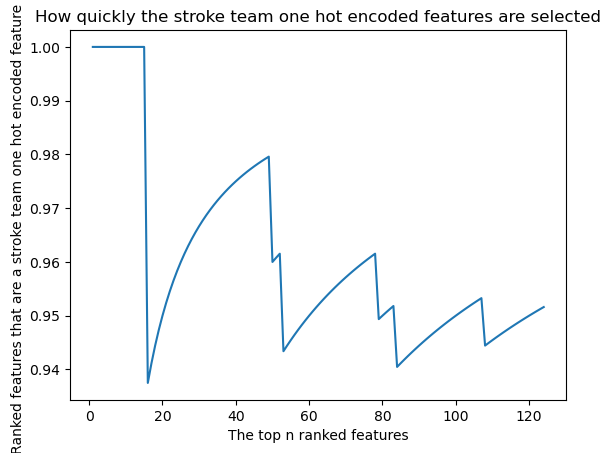

In [51]:
# Create a mask for feature names that don't contain string "team"
mask_exclude_team = ['team' not in i for i in list(df_feature_importance.index)]
mask_team = ['team' in i for i in list(df_feature_importance.index)]

list_pc_team_feature = [sum(mask_team[:i+1])/(i+1) for i in range(n_features)]

plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature)
plt.title('How quickly the stroke team one hot encoded features are selected')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

Now show the top 15 features (in terms of importance), excluding the one hot encoded stroke team features

In [52]:
# Use a mask for feature names that don't contain string "team"
df_feature_importance[mask_exclude_team].head(15)

,importance
stroke_severity,0.013840
prior_disability,0.008473
onset_to_thrombolysis_time,0.007885
age,0.005189
precise_onset_known,0.005025
any_afib_diagnosis,0.002687


## Section 1.2: SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

#### Get average SHAP values for this k-fold

Calculate the mean SHAP value for each feature (across all instances). 

The mean is calculated in three ways:

1. mean of raw values
2. mean of absolute values
3. absolute of mean of raw values

In a separate dataframe (df_mean_abs_shap), store the mean of the absolute SHAP values for this kfold (a row per feature). A dataframe per output class.

In [53]:
# Calculate mean SHAP value for each feature (across all instances), for
# this class
df_shap_values_mean = pd.DataFrame(index=input_features)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank (of mean abs)'] = df_shap_values_mean['mean_abs_shap'].rank(ascending=False).values

df_shap_values_mean = df_shap_values_mean.sort_values('mean_abs_shap', ascending=False)

df_shap_values_mean.head(15)

,mean_shap,abs_mean_shap,mean_abs_shap,rank (of mean abs)
stroke_severity,0.000467,0.000467,0.158484,1.0
onset_to_thrombolysis_time,0.005556,0.005556,0.095508,2.0
prior_disability,-0.000890,0.000890,0.045794,3.0
age,-0.012384,0.012384,0.039260,4.0
precise_onset_known,-0.003083,0.003083,0.013425,5.0
team_Luton and Dunstable Hospital,0.003987,0.003987,0.008525,6.0
team_Queen Alexandra Hospital Portsmouth,-0.003485,0.003485,0.007034,7.0
any_afib_diagnosis,-0.001500,0.001500,0.006080,8.0
team_Leicester Royal Infirmary,-0.002727,0.002727,0.005098,9.0
team_Royal Berkshire Hospital,-0.002340,0.002340,0.004824,10.0


Surprised that the one hot encoded stroke team features are not dominating the ranked list (as in the feature importance)

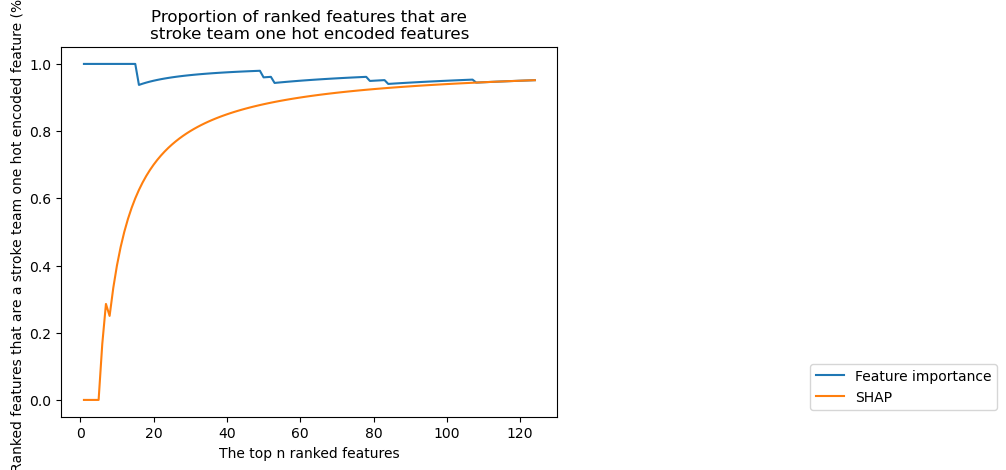

In [54]:
plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature, 
         label="Feature importance")

# Create a mask for feature names that don't contain string "team"
mask_exclude_team_features_shap = (
            ['team' not in i for i in list(df_shap_values_mean.index.values)])
mask_team_features_shap = (
            ['team' in i for i in list(df_shap_values_mean.index.values)])

list_pc_team_feature_shap = (
    [sum(mask_team_features_shap[:i+1])/(i+1) for i in range(n_features)])

plt.plot(list(range(1, (n_features + 1),1)), 
            list_pc_team_feature_shap, label=f"SHAP")
#plt.xlim((0,10))
plt.title('Proportion of ranked features that are\nstroke team one hot encoded features')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')
plt.legend(loc="lower right", bbox_to_anchor=(1.9, 0))
filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

## Section 1.3: Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values.

In [55]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance['importance'].values

# Data for the violin plot (for this class)
df_compare_shap_importance['SHAP (feature name)'] = (
                        df_shap_values_mean.index)
df_compare_shap_importance['SHAP (mean abs)'] = (df_shap_values_mean['mean_abs_shap'].values)
               
df_compare_shap_importance.head(10)

,Importance (feature name),Importance (median value),SHAP (feature name),SHAP (mean abs)
0,team_Royal Berkshire Hospital,0.034695,stroke_severity,0.158484
1,team_University Hospitals of North Tees and Ha...,0.023569,onset_to_thrombolysis_time,0.095508
2,team_Luton and Dunstable Hospital,0.023057,prior_disability,0.045794
3,team_William Harvey Hospital,0.022874,age,0.039260
4,team_University Hospitals Bristol Inpatient Team,0.019431,precise_onset_known,0.013425
5,team_North Devon District Hospital,0.019249,team_Luton and Dunstable Hospital,0.008525
6,team_Eastbourne District General Hospital,0.018261,team_Queen Alexandra Hospital Portsmouth,0.007034
7,team_York Hospital,0.017117,any_afib_diagnosis,0.006080
8,team_Maelor Hospital,0.016471,team_Leicester Royal Infirmary,0.005098
9,team_Great Western Hospital Swindon,0.016098,team_Royal Berkshire Hospital,0.004824


Plot all of the features, showing feature importance vs SHAP values.

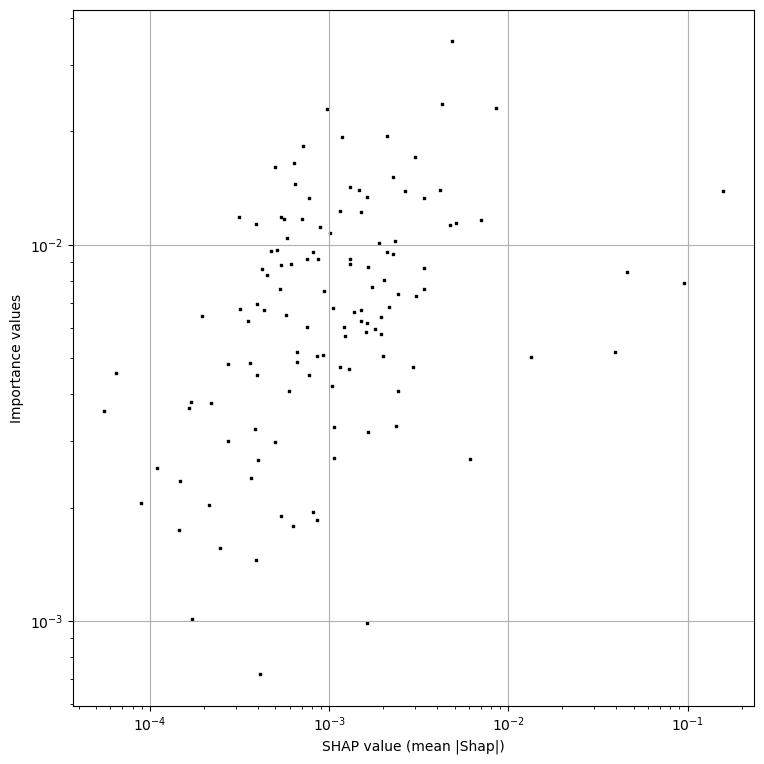

In [56]:
fig = plt.figure(figsize=(8, 8))

df_shap_importance = pd.DataFrame()
df_shap_importance['Shap'] =  df_shap_values_mean['mean_abs_shap']
df_shap_importance = df_shap_importance.merge(
                    df_feature_importance['importance'], 
                    left_index=True, right_index=True)
df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

ax1 = fig.add_subplot(111)
ax1.scatter(df_shap_importance['Shap'], df_shap_importance['importance'], 
            c='k', marker='s', s=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('SHAP value (mean |Shap|)')
ax1.set_ylabel('Importance values')
ax1.grid()

plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_shap_importance_correlation.jpg'))

plt.savefig(filename, dpi=300)
plt.show()


Show summary SHAP plot for each kfold.

Shows the mean absolute SHAP for each feature for each class output.

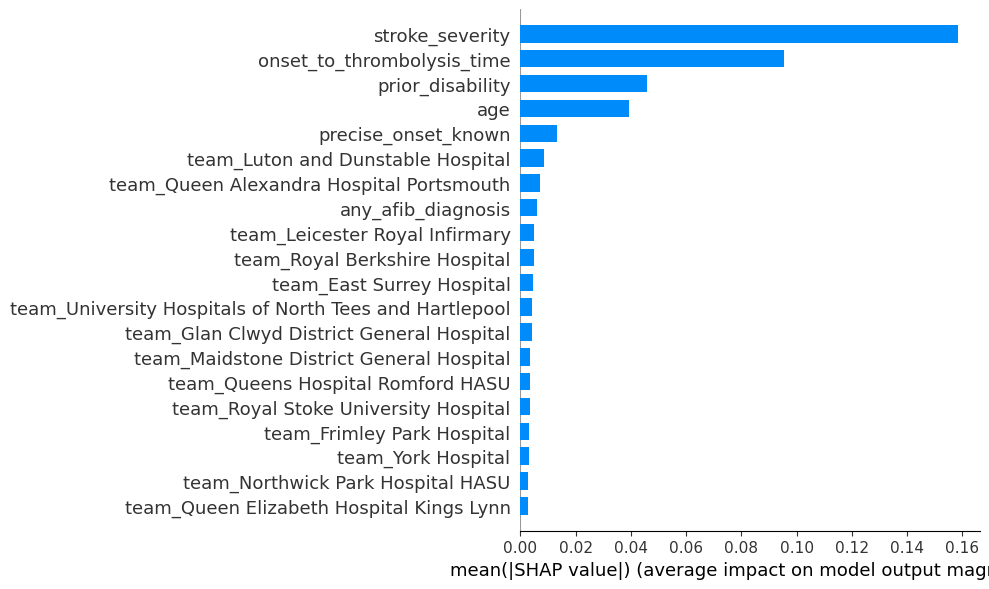

In [57]:
# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values, X_test.values, plot_type="bar", 
                    feature_names = X_test.columns,
                    show=False, plot_size=(10,6))
plt.tight_layout()
plt.show()

You can also see the summary_plot.

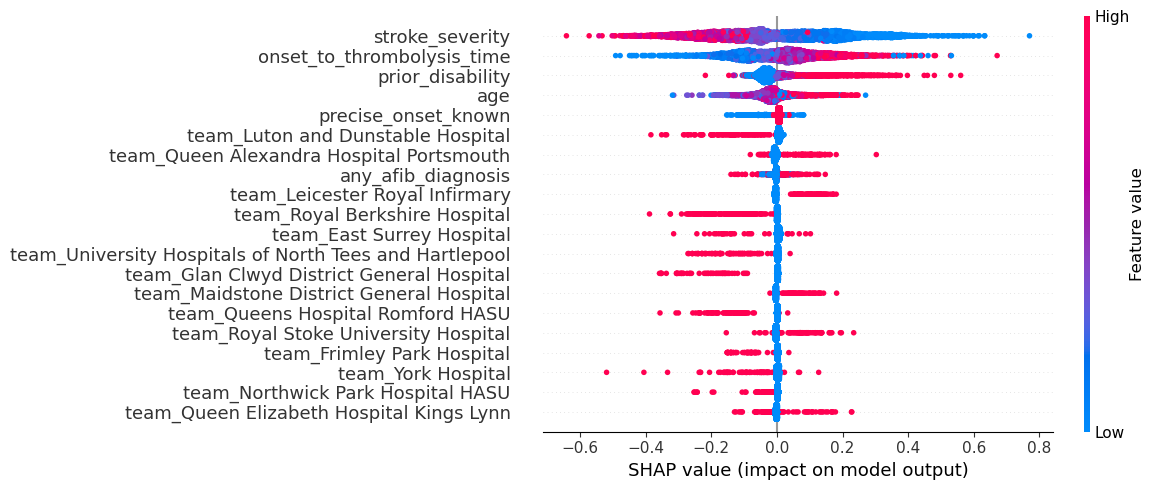

In [59]:
shap.summary_plot(shap_values, X_test.values, 
                feature_names=X_test.columns, show=False, 
                plot_size=(12,5))

plt.tight_layout()
plt.show()

Waterfall

In [60]:
instance = 0

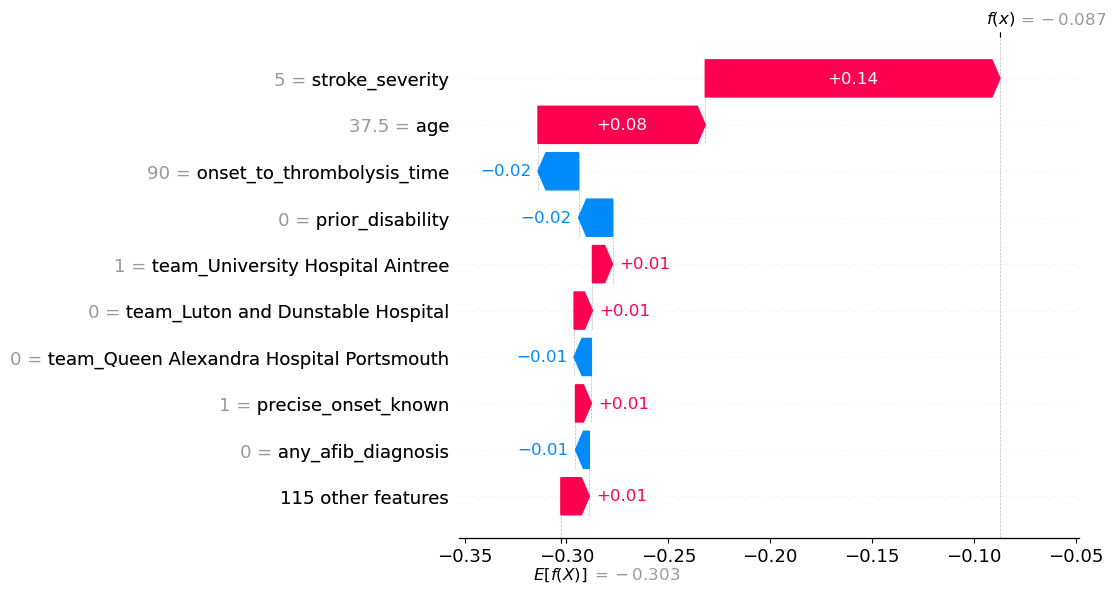

In [61]:
shap.waterfall_plot(shap.Explanation(values=shap_values[instance,:], 
                                     base_values=shap_values_extended.base_values[instance], 
                                     data=X_test.iloc[instance],  
                                     feature_names=X_test.columns.tolist()))

MAtrix of dependency plots

In [62]:
features_to_show = ["prior_disability", "stroke_severity", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features_show = len(features_to_show)

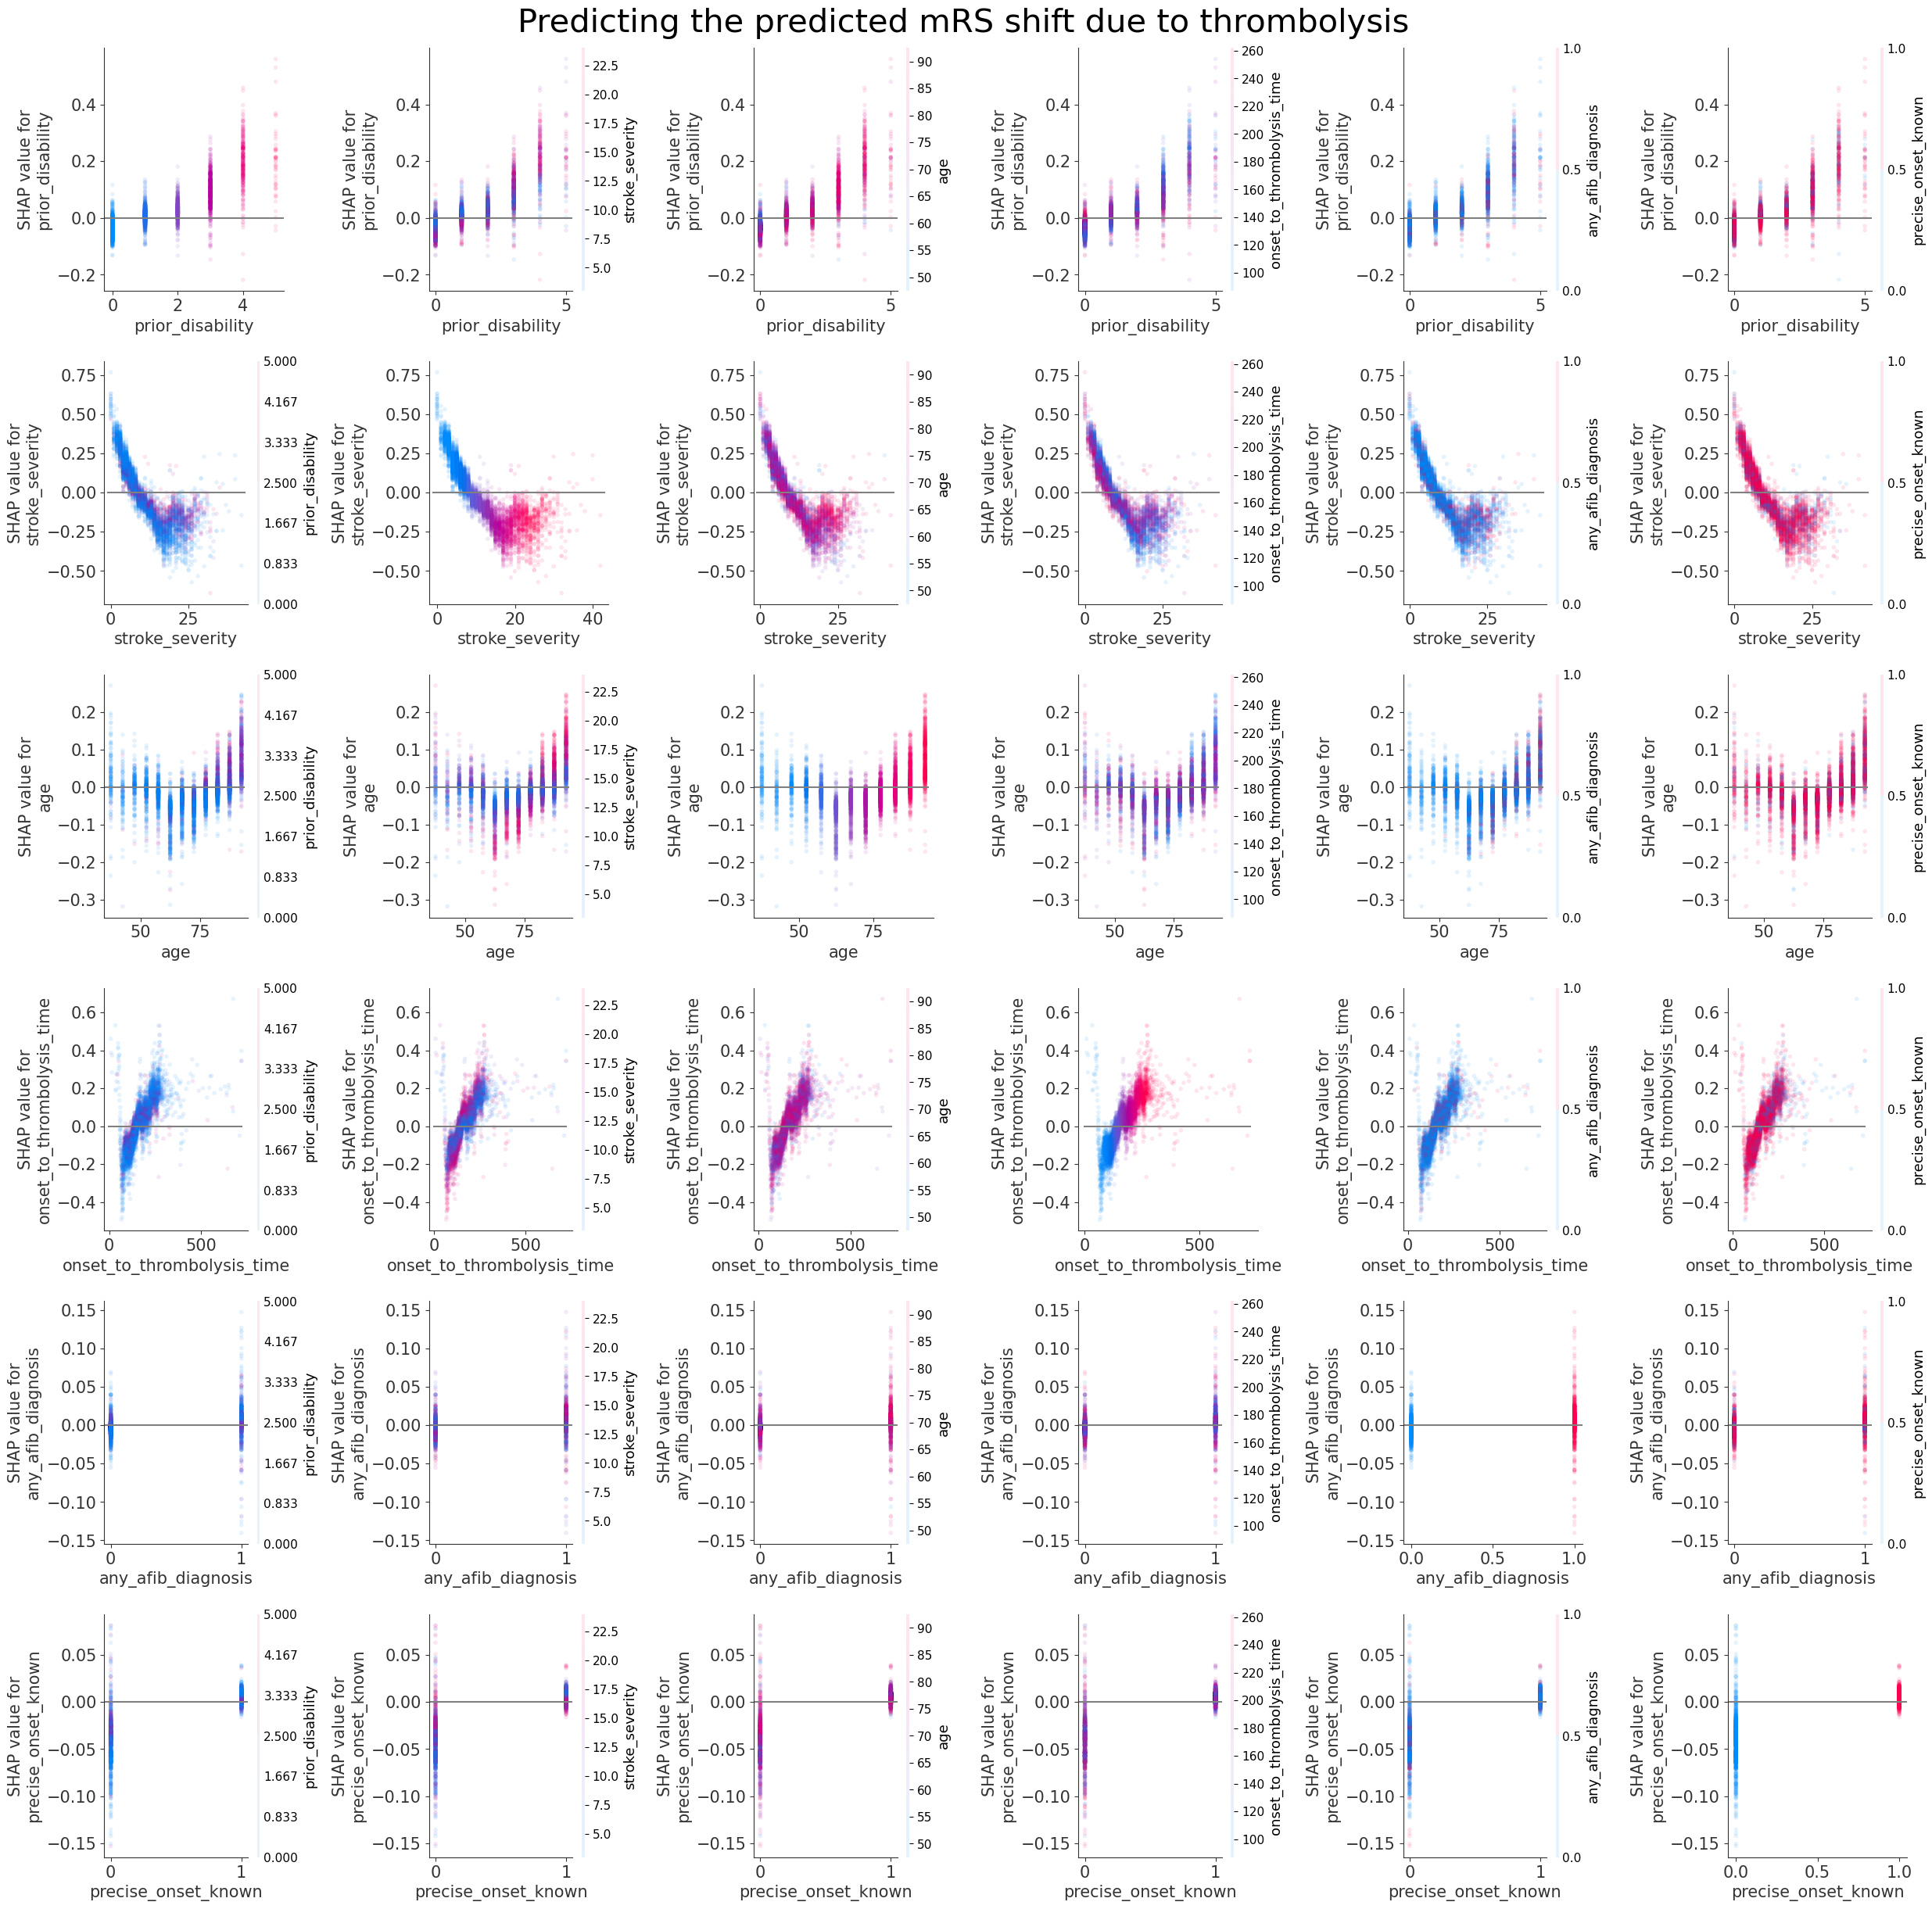

In [63]:
# Create a matrix of subplots per class. Each showing the relationship between
# each combination of features on the SHAP value.

# setup matrix of subplots
fig, axes = plt.subplots(nrows=n_features_show,
                         ncols=n_features_show)
axes = axes.ravel()

# Set overall title
fig.suptitle(f'Predicting the predicted mRS shift due to thrombolysis', fontsize=30)

# Initialise subplot counter
count = 0

# Loop through the features to display
for i in range(len(features_to_show)):
    # Loop through the features to display
    for j in range(len(features_to_show)):
        # Create the plot. Pass the axes
        shap.dependence_plot(ind=features_to_show[i], 
                            interaction_index=features_to_show[j], 
                            shap_values=shap_values, 
                            features=X_test.values, 
                            feature_names=X_test.columns,
                            show=False, ax=axes[count],
                            alpha=0.1)#, dot_size=2)
        # reduce the dot size/transparancy to reveal dense vs sparse areas
        #https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
        
        # Add line as shap=0
        axes[count].plot([-1, X_test[input_features[i]].max()+1],
                            [0,0],c='0.5')
        
        # Increase subplot counter
        count+=1

# Change font size for each subplot
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.tick_params(axis='both',which='major',labelsize=15)

# Visual propoerties of figure
dimension = 5 * 5
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
fig.tight_layout(pad=2)
plt.show()

Violin plots show the relationship between feature value and SHAP value for all of the features Output descriptive text to use in the paper to describe the differences a feature value had on the likelihood of receiving thromboylsis.

Resource: https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0 https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [64]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [69]:
def create_grid_of_violin_plots(features_violin,
                                shap_values_extended
                                ):
    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # Create figure
    fig = plt.figure(figsize=(12,14), constrained_layout=True)


    fig.suptitle(f'Predicting the predicted mRS shift due to thrombolysis', fontsize=20)

    # A subplot showing violin plot for each feature.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Determine number of rows of subplots by rounding up
    ncols = 2
    nrows = math.ceil(len(features_violin)/ncols)

    # Through each feature
    for n, feat in enumerate(features_violin):    
        
        # Get data and SHAP values
        feature_data = shap_values_extended[:, feat].data
        feature_shap = shap_values_extended[:, feat].values

        # If feature has more that 50 unique values, then assume it needs to be 
        # binned (otherwise assume they are unique categories)

        if np.unique(feature_data).shape[0] > 50:
            # bin the data, create a violin per bin
            
            # settings for the plot
            rotation = 45
            step = 30
            n_bins = min(11, np.int((feature_data.max())/step))
            
            # create list of bin values
            bin_list = [(i*step) for i in range(n_bins)]
            bin_list.append(feature_data.max())
#            if feat == "onset_to_thrombolysis_time":
#                # for -100 for no IVT
#                bin_list.insert(0, feature_data.min())

            # Number of instances per bin
            #counts, edges, plot = plt.hist(feature_data, bins=bin_list)
            counts, edges = np.histogram(feature_data, bins=bin_list, density=False)

            # create list of bins (the unique categories)
            category_list = [f'{i*step}-{((i+1)*step-1)}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
            category_list.append(f'{(n_bins-1)*step}+\n[n={int(counts[-1])}]')
#            if feat == "onset_to_thrombolysis_time":
#                # for -100 for no IVT
#                category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

            # bin the feature data
            feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                right=False)

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])

        else:
            # create a violin per unique value
            
            # settings for the plot
            rotation = 90
            
            # create list of unique categories in the feature data
            category_list = np.unique(feature_data)

            # Age needs to keep its decimal value (midpoint between 5 yrs)
            if feat != 'age':
                category_list = [int(i) for i in category_list]

            # create a list, each entry contains the corresponsing SHAP value for that 
            # category (or bin). A violin will represent each list.    
            count = []
            shap_per_category = []
            for category in category_list:
                mask = feature_data == category
                shap_per_category.append(feature_shap[mask])
                count.append(mask.sum())
#                if feat == 'stroke_severity':
#                    print(feature_shap[mask].max())

            if feat == 'age':
                # create text of x ticks
                category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

                # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                #   the other ages). To accommodate this, if last age category is "110"
                #   then overwrite the label with the correct band (100-120), and not
                #   107-112 as the above code would create.
                if category_list[-1] == '107-112':
                    category_list[-1] = '100-120'
            if feat == 'stroke_severity':
                # not enough space of chart for 2 lines fo x tick labels
                category_list = [f'{category_list[i]} [n={count[i]}]' for i in range(len(category_list))]
            else:
                category_list = [f'{category_list[i]}\n[n={count[i]}]' for i in range(len(category_list))]

        # create violin plot
        ax = fig.add_subplot(nrows,ncols,n+1)

        ax.violinplot(shap_per_category, showmeans=True, widths=0.9, 
                      showextrema=False)

        # Add line at Shap = 0
        feature_values = shap_values_extended[:, feat].data
        ax.plot([0, len(feature_values)], [0,0],c='0.5')   

        # customise the axes
        ax = set_ax(ax, category_list, feat, rotation=rotation)
        plt.subplots_adjust(bottom=0.15, wspace=0.05)

        # Adjust stroke severity tickmarks
        if feat == 'Stroke severity':
            ax.set_xticks(np.arange(1, len(category_list)+1, 2))
            ax.set_xticklabels(category_list[0::2])   
            
        # Add title
        ax.set_title(feat)
        
    plt.tight_layout(pad=2)
        
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + 
                            '_thrombolysis_shap_violin_all_' +
                            f'features.jpg'))
    fig.savefig(filename, 
                dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

In [72]:
shap_values_extended.base_values[0]

-0.30276033148963505

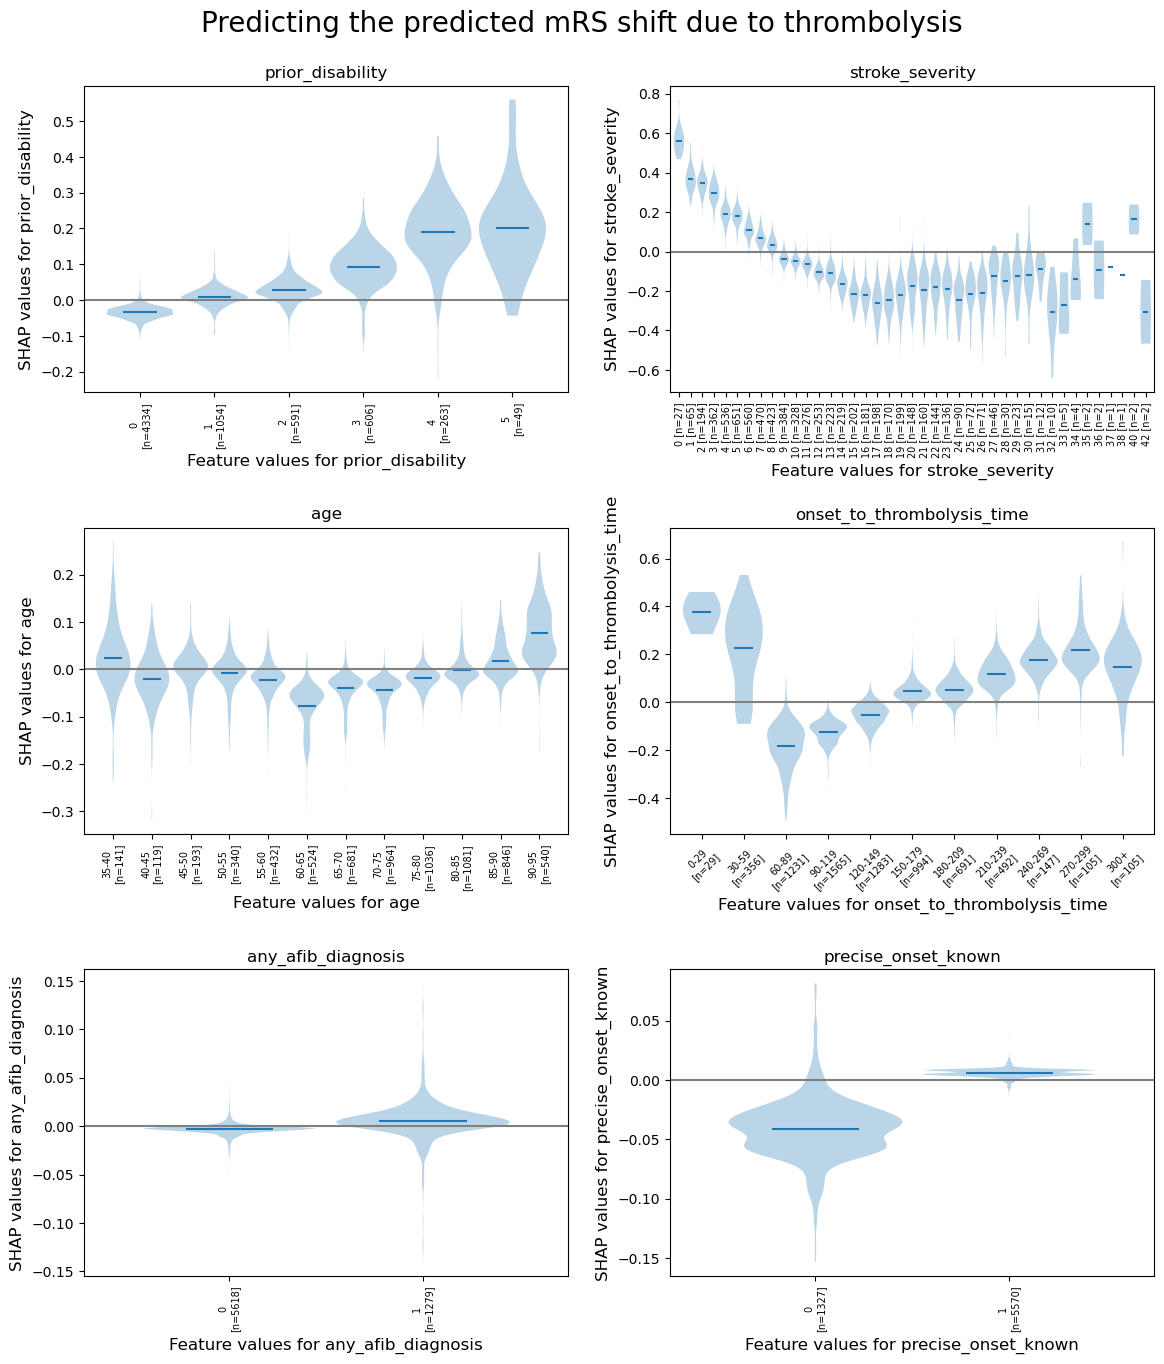

()

In [70]:
create_grid_of_violin_plots(features_to_show, 
                            shap_values_extended
                            )

https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

https://github.com/Iditc/Posts-on-Medium/blob/main/Explainable%20AI/Explainable%20AI%20(XAI)%20with%20SHAP_MultiClass%20Classification%20Problem.ipynb

https://github.com/slundberg/shap/issues/367


# WHEN TIME, LOOK AT notebook  230623_xgb_all_data_multiclass_shap.ipynb TO CHECK GOT ALL IN HERE